In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium
from folium import Choropleth, LayerControl, Tooltip
from google.colab import files
from shapely.geometry import box
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import kruskal
from scipy.stats import shapiro
!pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
#1.load data
data= pd.read_csv('https://github.com/kzw333/5160/raw/refs/heads/main/final4.csv')

#Data Exploration
#View the data structure
data.head()
data.isnull().sum()
data.dtypes
data.columns
healthdata= pd.read_csv('https://github.com/kzw333/5160/raw/refs/heads/main/FINAL-HEALTH-10.csv')
Disability= pd.read_csv('https://github.com/kzw333/5160/raw/refs/heads/main/10disability11.csv')
healthdata.head()
healthdata.isnull().sum()
healthdata.dtypes
#Accessibility data
Accessibility= pd.read_csv('https://github.com/kzw333/5160/raw/refs/heads/main/Healthcare%20Resources%20Accessibility%28Drive-time%29.csv')
#Lsoa data
lsoa_gdf = gpd.read_file("https://github.com/kzw333/5160/raw/refs/heads/main/Greater_Manchester_LSOA.gpkg")  # 或 .shp, .geojson

print(lsoa_gdf.head())
print(lsoa_gdf.columns)
# EPSG:27700
if lsoa_gdf.crs != 'EPSG:27700':
 lsoa_gdf = lsoa_gdf.to_crs('EPSG:27700')
print("大曼彻斯特 LSOA 数量（The number of LSOAs in Greater Manchester）：", lsoa_gdf['LSOA21CD'].nunique())


    LSOA21CD     LSOA21NM LSOA21NMW   BNG_E   BNG_N        LAT     LONG  \
0  E01004766  Bolton 005A            371186  411551  53.599739 -2.43687   
1  E01004767  Bolton 005B            371871  411508  53.599388 -2.42651   
2  E01004768  Bolton 001A            370034  413227  53.614738 -2.45444   
3  E01004769  Bolton 003A            371943  412792  53.610939 -2.42554   
4  E01004770  Bolton 003B            372075  412156  53.605228 -2.42349   

                                 GlobalID  \
0  {673373D2-E7C0-46FD-926F-96995E545025}   
1  {1D5ACDE6-7446-461D-99D0-9A8DFBD2404B}   
2  {8C01D73B-9853-400A-9CA2-28B649073F19}   
3  {71BDBF91-3C99-477F-A663-3B3614980D3C}   
4  {AEA3A766-915C-4091-B6BD-D76E6451192D}   

                                            geometry  
0  MULTIPOLYGON (((371471.66 411973.856, 371471.6...  
1  MULTIPOLYGON (((371827 411853, 371821 411855, ...  
2  MULTIPOLYGON (((370256.687 414697.312, 370235....  
3  MULTIPOLYGON (((371650.784 413181.515, 371647....  
4  

In [ ]:
# “Bad health”+“Very bad health”=“Poor health”
healthdata['Poor health'] = healthdata['Bad health'] + healthdata['Very bad health']

# List of health status columns
health_cols = ['Very good health', 'Good health',  'Poor health']
# Calculate percentage for each health status
for col in health_cols:
    healthdata[col + '_pct'] = healthdata[col] / healthdata['Total: All usual residents'] * 100

# 查看结果示例
print(healthdata[['Very good health', 'Very good health_pct', 'Poor health', 'Poor health_pct']].head())

   Very good health  Very good health_pct  Poor health  Poor health_pct
0               918             57.554859           49         3.072100
1               888             54.814815           45         2.777778
2               800             54.495913           44         2.997275
3               788             57.267442           33         2.398256
4               902             55.782313           42         2.597403


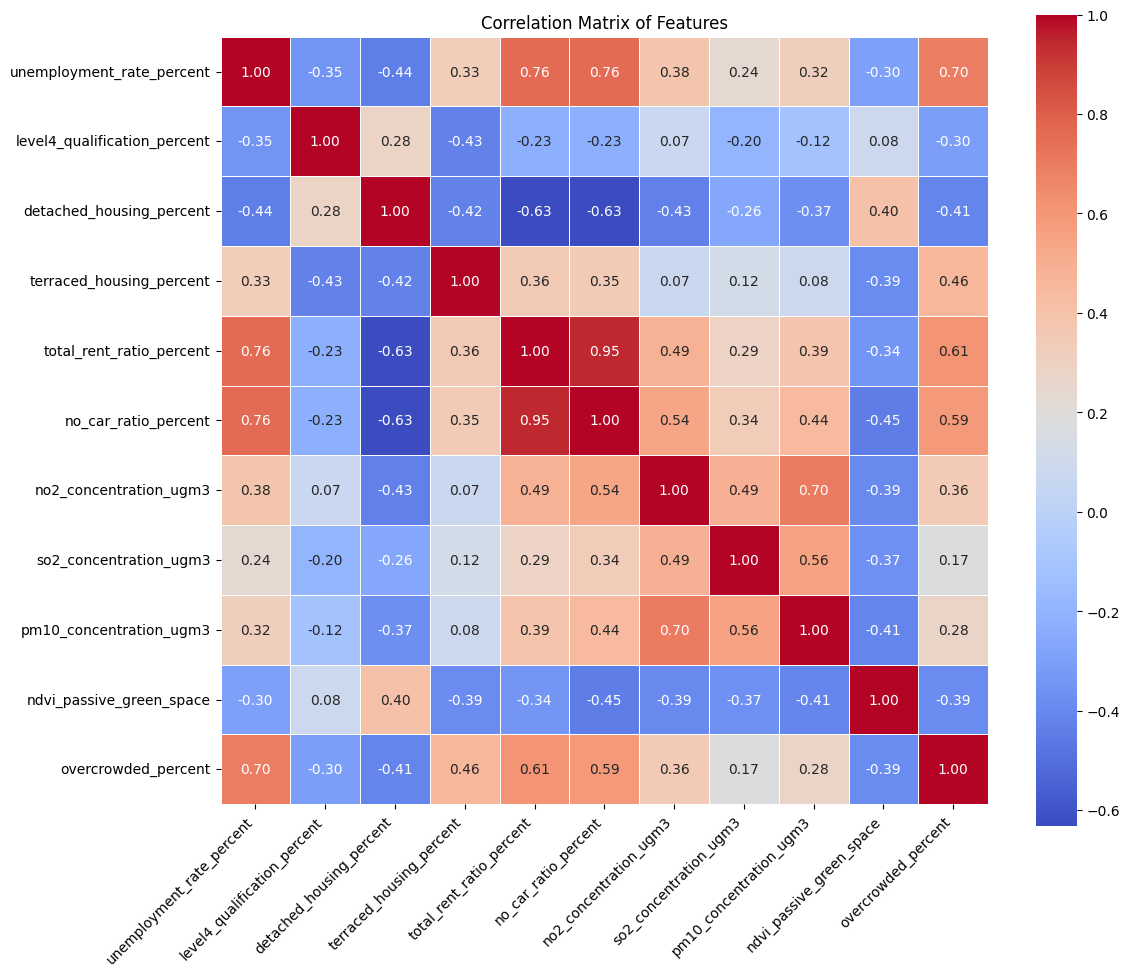

                        variable        VIF
0      unemployment_rate_percent   3.433227
1   level4_qualification_percent   1.626904
2       detached_housing_percent   2.039397
3       terraced_housing_percent   1.754376
4       total_rent_ratio_percent  12.084775
5           no_car_ratio_percent  12.975908
6         no2_concentration_ugm3   2.762592
7         so2_concentration_ugm3   1.640324
8        pm10_concentration_ugm3   2.386347
9       ndvi_passive_green_space   1.853854
10           overcrowded_percent   2.430860


,unemployment_rate_percent,level4_qualification_percent,detached_housing_percent,terraced_housing_percent,total_rent_ratio_percent,no2_concentration_ugm3,so2_concentration_ugm3,pm10_concentration_ugm3,ndvi_passive_green_space,overcrowded_percent
0,-1.010988,0.558960,3.058749,-1.170880,-1.452846,-1.570106,-1.486149,-1.445205,1.221533,-0.820119
1,-1.033790,0.932936,1.578095,-0.002376,-0.983903,-2.163557,-2.176622,-2.145085,0.926074,-0.816785
2,-0.369996,1.110416,2.807508,-0.918162,-1.409032,-1.826105,-1.831385,-1.671636,1.123046,-0.788446
3,-0.382664,0.679393,1.045250,-0.084242,-1.032489,-1.178351,-1.203682,-1.002634,-0.058791,-0.710096
4,-0.704427,0.909959,1.700738,-0.639002,-1.265876,-1.643803,-1.611689,-1.465789,0.926074,-0.973486


In [ ]:
#data cleaning
#排除非数值列（object 类型），只保留需要标准化的变量
#Exclude non-numeric columns (object type), keeping only the variables that need to be standardized
columns_to_scale = [
    'unemployment_rate_percent',
    'level4_qualification_percent',
    'detached_housing_percent',
    'terraced_housing_percent',
    'total_rent_ratio_percent',
    'no_car_ratio_percent',
    'no2_concentration_ugm3',
    'so2_concentration_ugm3',
    'pm10_concentration_ugm3',
    'ndvi_passive_green_space',

    'overcrowded_percent'
]

# 执行标准化
# Perform standardization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_to_scale])

# 转换为 DataFrame，保留列名
# Convert to DataFrame, keeping column names
scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# 如果你想保留原始的 LSOA 编号和名称，可以这样合并
# If you want to keep the original LSOA codes and names, merge them like this
scaled_df['LSOA21CD'] = data['LSOA21CD'].values
scaled_df['area_name'] = data['2021 super output area - lower layer'].values

scaled_df.head()


# 只取需要分析的数值列（你做标准化用的那一组）
# Select only the numeric columns needed for analysis (the ones used for standardization)
X_corr = scaled_df[columns_to_scale]

# 计算相关系数矩阵
# Compute the correlation matrix
corr_matrix = X_corr.corr()

# 设置图形大小
# Set figure size
plt.figure(figsize=(12, 10))

# 绘制热力图
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)

# 设置标题
# Set title
plt.title("Correlation Matrix of Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 构建 DataFrame，只保留标准化变量
X = scaled_df[columns_to_scale]

# 计算 VIF
# Compute VIF (Variance Inflation Factor)
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)


filtered_variables = [
    'unemployment_rate_percent',
    'level4_qualification_percent',
    'detached_housing_percent',
    'terraced_housing_percent',
    'total_rent_ratio_percent',   # ← 保留
    # 'no_car_ratio_percent',     ← 已剔除
    'no2_concentration_ugm3',
    'so2_concentration_ugm3',
    'pm10_concentration_ugm3',
    'ndvi_passive_green_space',
    'overcrowded_percent'
]

scaled_df[filtered_variables].head()


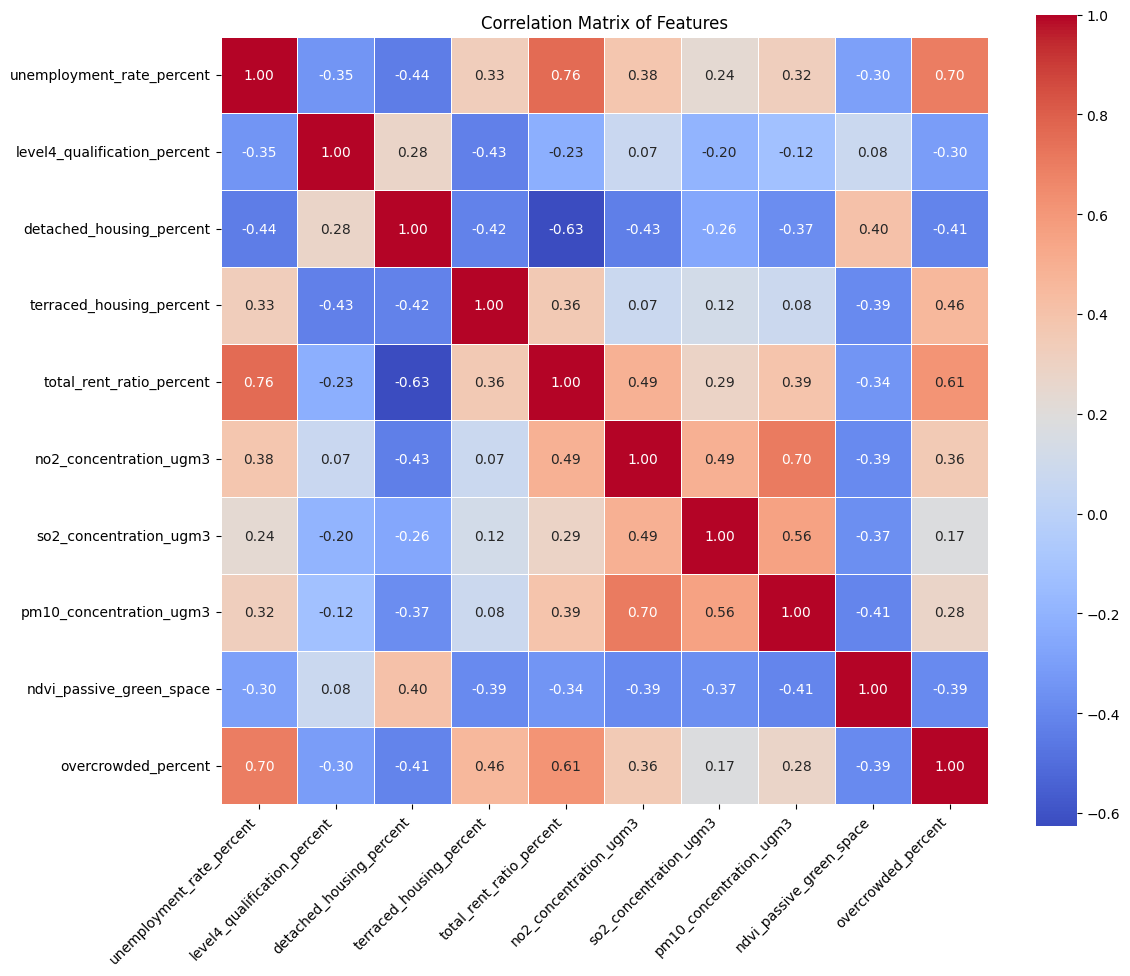

                       variable       VIF
4      total_rent_ratio_percent  3.454447
0     unemployment_rate_percent  3.265301
5        no2_concentration_ugm3  2.690417
7       pm10_concentration_ugm3  2.382972
9           overcrowded_percent  2.364963
2      detached_housing_percent  2.031347
3      terraced_housing_percent  1.740259
6        so2_concentration_ugm3  1.640094
1  level4_qualification_percent  1.616890
8      ndvi_passive_green_space  1.612933


In [ ]:
# Select only the numeric columns needed for analysis (the set you used for standardization)
# 只取需要分析的数值列（你做标准化用的那一组）
X_corr = scaled_df[filtered_variables]

# Compute the correlation matrix
# 计算相关系数矩阵
corr_matrix = X_corr.corr()

# Set figure size
# 设置图形大小
plt.figure(figsize=(12, 10))

# Plot heatmap
# 绘制热力图
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)

# Set title
# 设置标题
plt.title("Correlation Matrix of Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Construct DataFrame (if not already constructed)
# 构建 DataFrame（如果你还没构建）
X_vif = pd.DataFrame(X_corr, columns=filtered_variables)

# Compute VIF
# 计算 VIF
vif_data = pd.DataFrame()
vif_data['variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display results
# 显示结果
print(vif_data.sort_values(by='VIF', ascending=False))


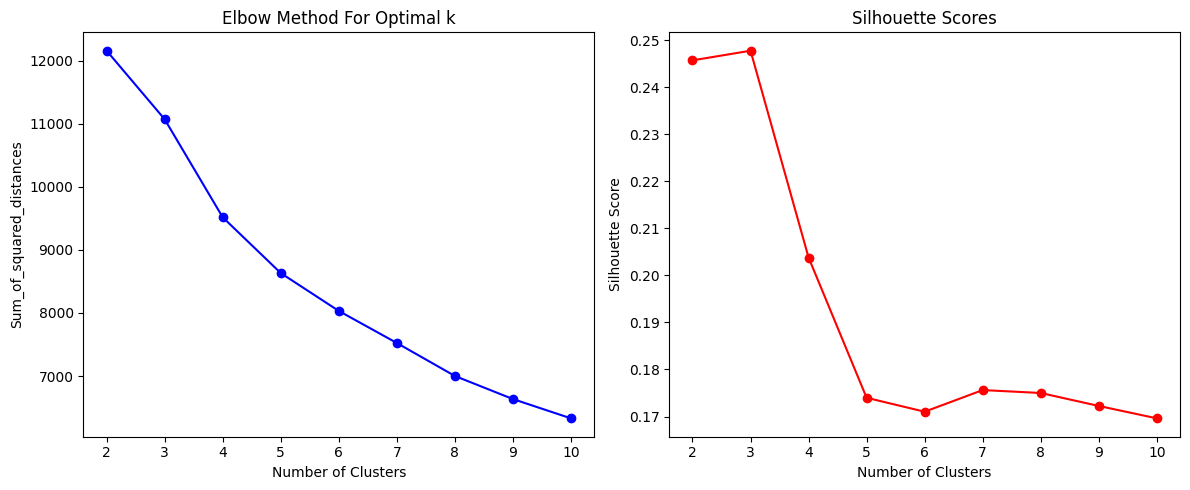

In [ ]:
# 1. Select standardized variables for clustering (filtered_variables is the list of column names)
# 1. 选择标准化后的变量列用于聚类（filtered_variables 是列名列表）
X = scaled_df[filtered_variables]

# 2. Initialize storage lists
# 2. 初始化存储列表
wcss = []          # Within-cluster sum of squares (WCSS) / 簇内平方和
sil_scores = []    # Silhouette scores / 轮廓系数
K_range = range(2, 11)  # Range of k values to test / 待测试的聚类数范围

# 3. Compute clustering metrics for different k
# 3. 计算不同 k 的聚类效果
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans / 初始化 KMeans
    kmeans.fit(X)                                    # Fit model / 拟合模型
    wcss.append(kmeans.inertia_)                     # Append WCSS / 存储簇内平方和
    sil_scores.append(silhouette_score(X, kmeans.labels_))  # Compute silhouette score / 计算轮廓系数

# 4. Visualize Elbow Method and Silhouette Scores
# 4. 可视化肘部法和轮廓系数
plt.figure(figsize=(12,5))

# 4a. Elbow Method plot
# 4a. 绘制肘部法图
plt.subplot(1,2,1)
plt.plot(K_range, wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum_of_squared_distances')

# 4b. Silhouette Scores plot
# 4b. 绘制轮廓系数图
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [ ]:
# 1. Perform KMeans clustering with k=4
# 1. 执行 KMeans 聚类，聚类数 k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
scaled_df['cluster'] = kmeans.fit_predict(X)  # Assign cluster labels / 生成簇标签并加入 DataFrame

# 2. Preview the first and last few rows to confirm
# 2. 查看前几行和后几行以确认簇标签
print(scaled_df[['LSOA21CD', 'cluster'] + filtered_variables].head())
print(scaled_df[['LSOA21CD', 'cluster'] + filtered_variables].tail())

# 3. Statistical analysis: mean of each cluster
# 3. 统计分析：计算每个簇的各变量均值
cluster_summary = scaled_df.groupby('cluster')[filtered_variables].mean()
print(cluster_summary)




    LSOA21CD  cluster  unemployment_rate_percent  \
0  E01004768        1                  -1.010988   
1  E01004803        1                  -1.033790   
2  E01004804        1                  -0.369996   
3  E01004807        1                  -0.382664   
4  E01004808        1                  -0.704427   

   level4_qualification_percent  detached_housing_percent  \
0                      0.558960                  3.058749   
1                      0.932936                  1.578095   
2                      1.110416                  2.807508   
3                      0.679393                  1.045250   
4                      0.909959                  1.700738   

   terraced_housing_percent  total_rent_ratio_percent  no2_concentration_ugm3  \
0                 -1.170880                 -1.452846               -1.570106   
1                 -0.002376                 -0.983903               -2.163557   
2                 -0.918162                 -1.409032               -1.826105

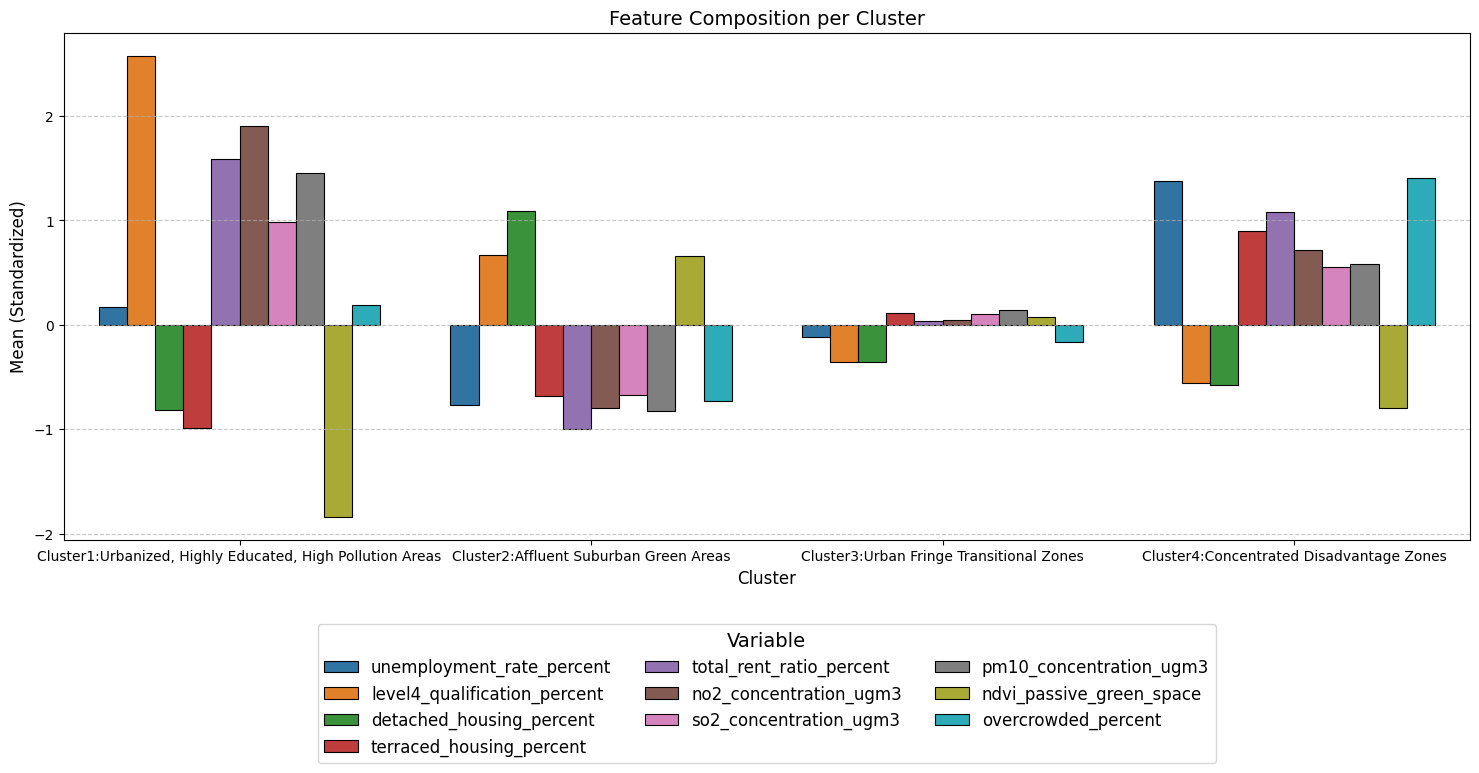

In [ ]:
# 3. Reshape to long format for easier plotting
# 3. 转换成长格式，方便绘图
cluster_summary_long = cluster_summary.reset_index().melt(
    id_vars='cluster',
    var_name='variable',
    value_name='mean_value'
)

# 4. Define cluster name mapping
# 4. 自定义簇名称映射
cluster_name_map = {
    'cluster1': 'Cluster1:Urbanized, Highly Educated, High Pollution Areas',
    'cluster2': 'Cluster2:Affluent Suburban Green Areas',
    'cluster3': 'Cluster3:Urban Fringe Transitional Zones',
    'cluster4': 'Cluster4:Concentrated Disadvantage Zones'
}

# Convert cluster numbers to 'cluster1', 'cluster2', etc.
# 先改成 'cluster1' 这种格式
cluster_summary_long['cluster'] = cluster_summary_long['cluster'].apply(lambda x: f'cluster{x+1}')

# Map to custom descriptive names
# 再替换成自定义名称
cluster_summary_long['cluster'] = cluster_summary_long['cluster'].map(cluster_name_map)

# 5. Custom color palette to ensure distinct colors
# 5. 自定义颜色，保证颜色区分度高
custom_palette = sns.color_palette("tab10", n_colors=len(filtered_variables))

# 6. Plot bar chart
# 6. 绘制条形图
plt.figure(figsize=(15,8))
barplot = sns.barplot(
    data=cluster_summary_long,
    x='cluster',
    y='mean_value',
    hue='variable',
    palette=custom_palette,
    edgecolor='black',
    linewidth=0.8
)

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Mean (Standardized)', fontsize=12)
plt.title('Feature Composition per Cluster', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Legend at bottom center, multiple columns
# 图例放底部居中，多列显示
plt.legend(
    title='Variable',
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    ncol=3,
    fontsize=12,
    title_fontsize=14
)

# Add horizontal grid lines for easier comparison
# 加横向网格线，方便比较数值高度
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2901825254.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('Set2', len(cluster_name_map))
/tmp/ipython-input-2901825254.py:31: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  merged_gdf.plot(


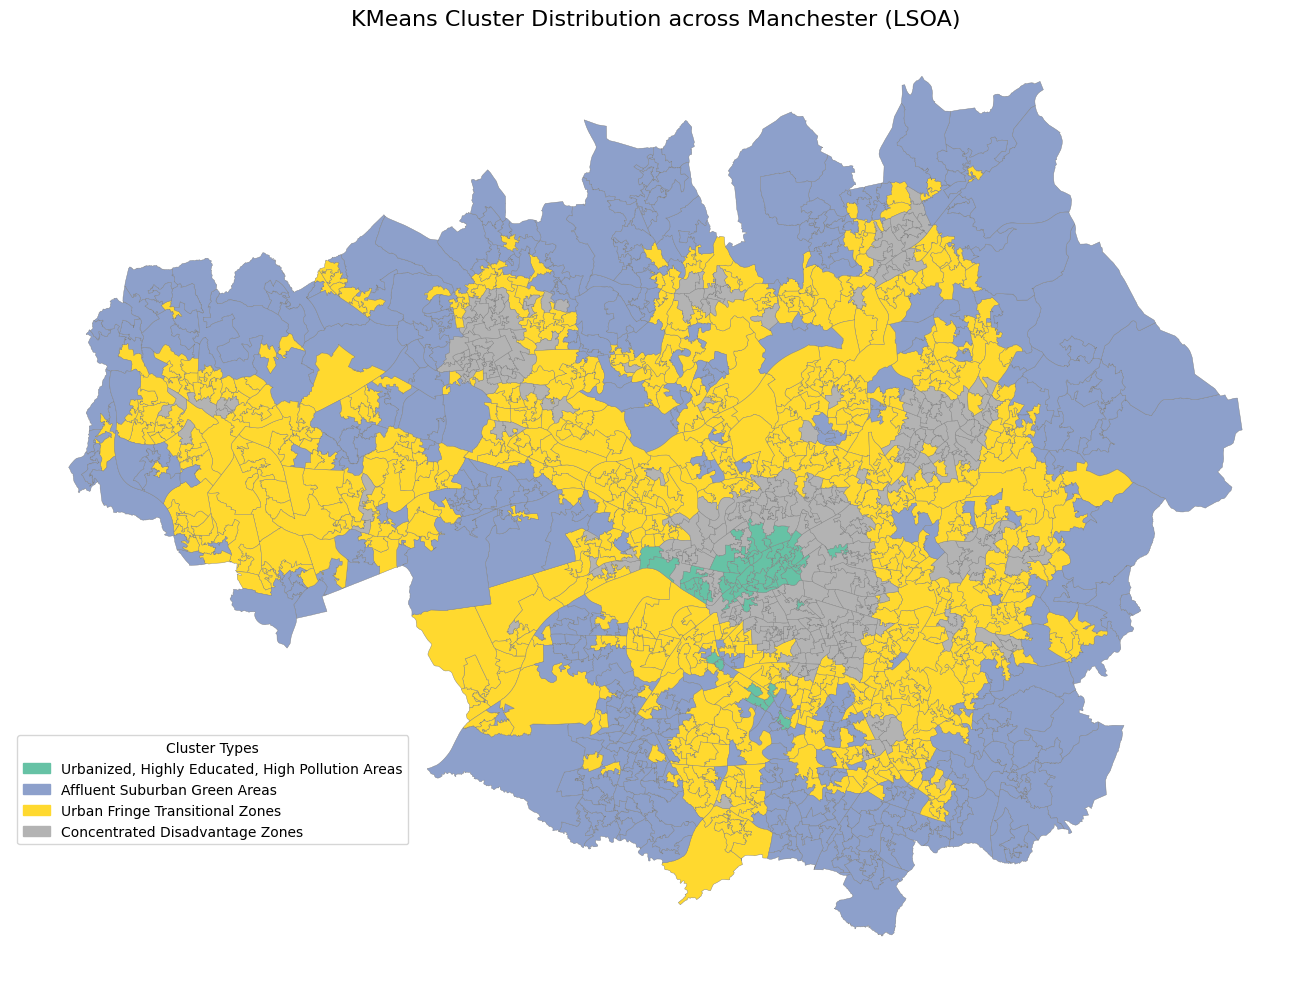

In [ ]:


# 1. Extract cluster results from scaled_df
# 1. 从 scaled_df 提取聚类结果列
cluster_df = scaled_df[['LSOA21CD', 'cluster']].copy()

# Cluster label mapping
# 聚类标签字典
cluster_name_map = {
    0: 'Urbanized, Highly Educated, High Pollution Areas',
    1: 'Affluent Suburban Green Areas',
    2: 'Urban Fringe Transitional Zones',
    3: 'Concentrated Disadvantage Zones'
}

# Map numeric cluster to descriptive labels
# 将数字聚类标签映射为描述性标签
cluster_df['cluster_label'] = cluster_df['cluster'].map(cluster_name_map)

# Merge spatial data with cluster labels
# 合并空间数据和聚类标签
merged_gdf = lsoa_gdf.merge(cluster_df, on='LSOA21CD', how='left')

# Color mapping by cluster_label
# 颜色映射以 cluster_label 为 Key
color_palette = plt.cm.get_cmap('Set2', len(cluster_name_map))
color_map = {label: mcolors.rgb2hex(color_palette(i)) for i, label in enumerate(cluster_name_map.values())}

# Plotting
# 绘图
fig, ax = plt.subplots(figsize=(16, 10))

merged_gdf.plot(
    column='cluster_label',        # 按 cluster_label 列上色
    categorical=True,              # 分类变量
    legend=False,                  # 不自动显示图例
    color=merged_gdf['cluster_label'].map(color_map),  # 自定义颜色
    linewidth=0.3,                 # 边界线宽
    edgecolor='grey',              # 边界线颜色
    ax=ax
)

# Manually add legend
# 手动添加图例
unique_labels = list(cluster_name_map.values())
handles = [mpatches.Patch(color=color_map[label], label=label) for label in unique_labels]
ax.legend(
    handles=handles,
    title='Cluster Types',
    loc='center left',
    bbox_to_anchor=(0, 0.2)
)

# Title and remove axes
# 设置标题并去掉坐标轴
ax.set_title("KMeans Cluster Distribution across Manchester (LSOA)", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()

# Optionally save to GeoJSON
# 可选：保存为 GeoJSON
# merged_gdf.to_file("manchester_clusters.geojson", driver='GeoJSON')
# from google.colab import files
# files.download('manchester_clusters.geojson')




In [ ]:
# 读取 Borough 边界数据 / Read Borough boundary data
boroughs_gdf = gpd.read_file('https://github.com/kzw333/5160/raw/refs/heads/main/Local_Authority_Districts.gpkg')
boroughs_gdf = boroughs_gdf.to_crs(epsg=4326)

# 读取 LSOA 聚类结果（merged_gdf 这里假设你已经提前准备好，包含 cluster 列） / Read LSOA clustering result (merged_gdf is assumed to be prepared with 'cluster' column)
merged_gdf = merged_gdf.to_crs(epsg=4326)

# Greater Manchester 10个Borough名称 / Names of 10 Boroughs in Greater Manchester
gm_boroughs = [
    'Manchester', 'Salford', 'Trafford', 'Stockport', 'Tameside',
    'Oldham', 'Rochdale', 'Bury', 'Bolton', 'Wigan'
]

# 只保留大曼彻斯特的 Borough 边界 / Keep only Greater Manchester Borough boundaries
gm_boroughs_gdf = boroughs_gdf[boroughs_gdf['LAD24NM'].isin(gm_boroughs)]

# Cluster Name Map / Mapping of cluster numbers to descriptive names
cluster_name_map = {
    0: 'Urbanized, Highly Educated, High Pollution Areas',
    1: 'Affluent Suburban Green Areas',
    2: 'Urban Fringe Transitional Zones',
    3: 'Concentrated Disadvantage Zones'
}

# 配色 / Color palette
color_palette = plt.cm.get_cmap('Set2', len(cluster_name_map))
color_map = {i: mcolors.rgb2hex(color_palette(i)) for i in cluster_name_map.keys()}

# 样式函数 / Style function for LSOA clusters
def style_function(feature):
    cluster_num = feature['properties']['cluster']
    return {
        'fillOpacity': 0.6,
        'weight': 0.5,
        'color': 'grey',
        'fillColor': color_map.get(cluster_num, 'white')
    }

# Borough 边界样式 / Style function for Borough boundaries
def borough_style(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color': 'black'
    }

# 创建folium地图 / Create folium map
m = folium.Map(location=[53.4808, -2.2426], zoom_start=10)

# 添加 LSOA 聚类图层 / Add LSOA cluster layer
folium.GeoJson(
    merged_gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['LSOA21NM', 'cluster_label'],
        aliases=['LSOA Name', 'Cluster'],
        sticky=True
    ),
    name='Clusters'
).add_to(m)

# 仅添加Greater Manchester的 Borough 边界 / Add only Greater Manchester Borough boundaries
folium.GeoJson(
    gm_boroughs_gdf,
    style_function=borough_style,
    tooltip=folium.GeoJsonTooltip(
        fields=['LAD24NM'],
        aliases=['Borough'],
        sticky=True
    ),
    name='Greater Manchester Boundary'
).add_to(m)

# 添加图例 / Add legend
legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; width: 250px; background: white; z-index:9999; padding: 10px; border:1px solid black;">'
legend_html += '<h4>Cluster Types</h4>'
for i, name in cluster_name_map.items():
    color = color_map[i]
    legend_html += f'<div><span style="background:{color};width:20px;height:10px;display:inline-block;margin-right:5px;"></span>{name}</div>'
legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# 添加图层控制 / Add layer control
folium.LayerControl().add_to(m)

# 保存并下载，文件名更换 / Save and download map with new filename
m.save('boroughs-greater_manchester_clusters_map.html')
files.download('boroughs-greater_manchester_clusters_map.html')



/tmp/ipython-input-2262325775.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('Set2', len(cluster_name_map))


                                                 Very good health_pct  \
                                                                count   
cluster_label                                                           
Affluent Suburban Green Areas                                   491.0   
Concentrated Disadvantage Zones                                 340.0   
Urban Fringe Transitional Zones                                 811.0   
Urbanized, Highly Educated, High Pollution Areas                 60.0   

                                                                       \
                                                       mean       std   
cluster_label                                                           
Affluent Suburban Green Areas                     51.935422  5.019020   
Concentrated Disadvantage Zones                   47.682670  5.260194   
Urban Fringe Transitional Zones                   46.156212  4.572412   
Urbanized, Highly Educated, High Pollution Areas  

/tmp/ipython-input-574033431.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-574033431.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


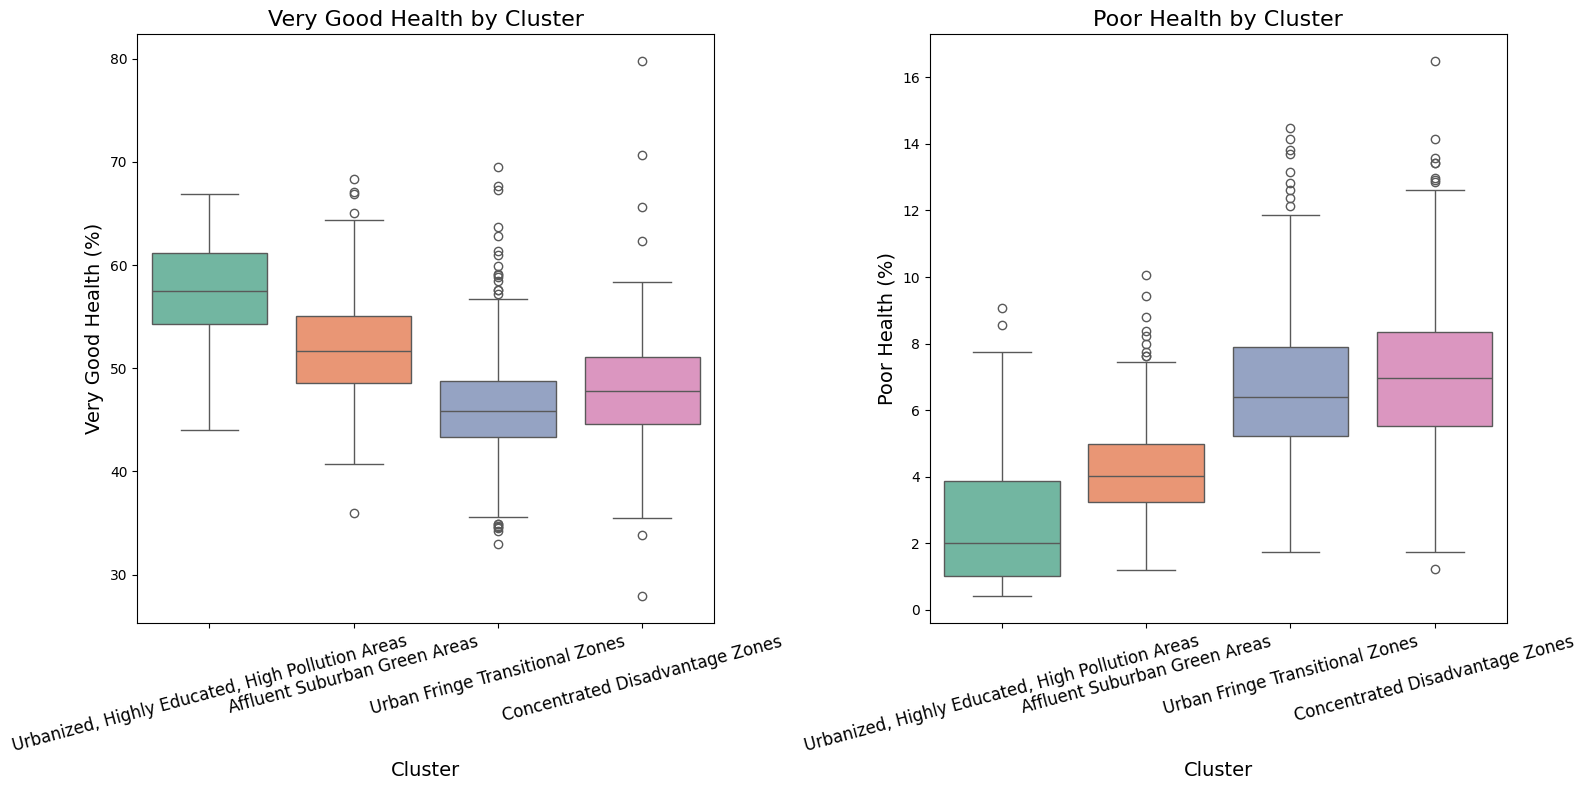

In [ ]:
merged_gdf = lsoa_gdf.merge(cluster_df, on='LSOA21CD', how='left')\
                     .merge(healthdata[['LSOA21CD', 'Very good health_pct', 'Poor health_pct']], on='LSOA21CD', how='left')\
                      .merge(Disability[['LSOA21CD', 'disability_rate', 'healthy_rate']], on='LSOA21CD', how='left')

# Descriptive statistics: compute summary statistics for health by cluster
health_stats = merged_gdf.groupby('cluster_label')[['Very good health_pct', 'Poor health_pct']].describe()
print(health_stats)

import seaborn as sns
import matplotlib.pyplot as plt

# Manually specify the order of clusters for plotting
cluster_order = [
    'Urbanized, Highly Educated, High Pollution Areas',
    'Affluent Suburban Green Areas',
    'Urban Fringe Transitional Zones',
    'Concentrated Disadvantage Zones'
]

plt.figure(figsize=(16, 8))

# Boxplot for "Very good health" by cluster
plt.subplot(1, 2, 1)
sns.boxplot(
    x='cluster_label',
    y='Very good health_pct',
    data=merged_gdf,
    order=cluster_order,  # Ensure the order of clusters
    palette='Set2'         # Color palette
)
plt.title('Very Good Health by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)  # X-axis label
plt.ylabel('Very Good Health (%)', fontsize=14)  # Y-axis label
plt.xticks(rotation=15, fontsize=12)  # Rotate x-axis labels for readability

# Boxplot for "Poor health" by cluster
plt.subplot(1, 2, 2)
sns.boxplot(
    x='cluster_label',
    y='Poor health_pct',
    data=merged_gdf,
    order=cluster_order,  # Ensure the order of clusters
    palette='Set2'
)
plt.title('Poor Health by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)  # X-axis label
plt.ylabel('Poor Health (%)', fontsize=14)  # Y-axis label
plt.xticks(rotation=15, fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display plots


                                                 disability_rate             \
                                                           count       mean   
cluster_label                                                                 
Affluent Suburban Green Areas                              491.0  15.842363   
Concentrated Disadvantage Zones                            340.0  18.828353   
Urban Fringe Transitional Zones                            811.0  20.279482   
Urbanized, Highly Educated, High Pollution Areas            60.0  12.243333   

                                                                          \
                                                       std   min     25%   
cluster_label                                                              
Affluent Suburban Green Areas                     3.003227  8.57  13.850   
Concentrated Disadvantage Zones                   4.584371  8.68  15.475   
Urban Fringe Transitional Zones                   3.897264  8.94  

/tmp/ipython-input-1821593258.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1821593258.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


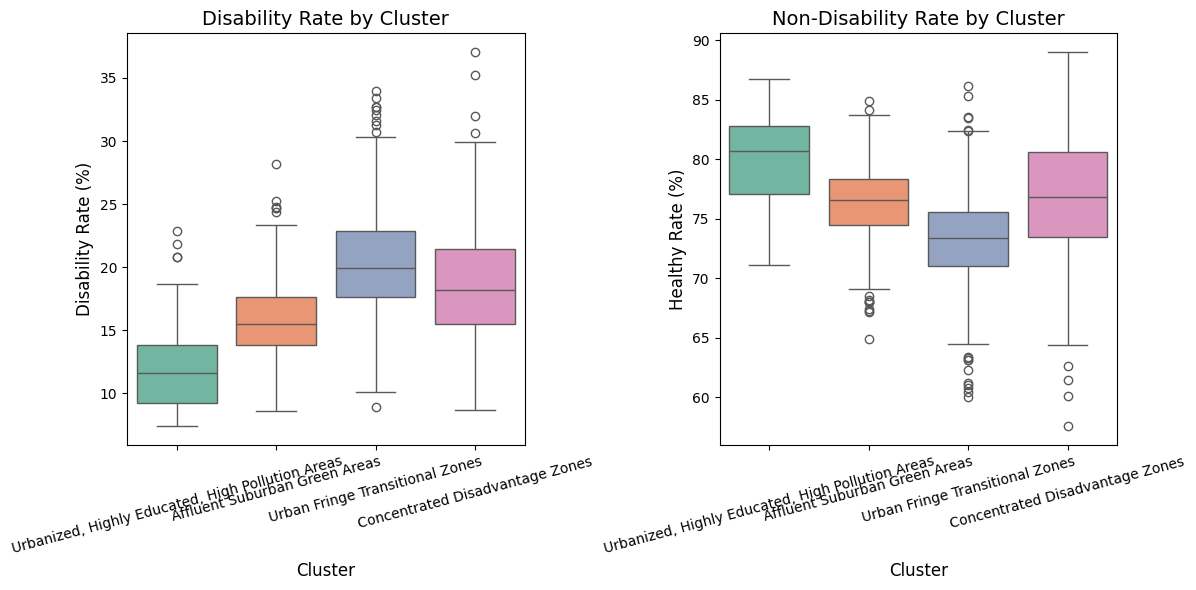

In [ ]:
merged_gdf = lsoa_gdf.merge(cluster_df, on='LSOA21CD', how='left')\
                     .merge(Disability[['LSOA21CD', 'disability_rate','healthy_rate']], on='LSOA21CD', how='left')

# Descriptive statistics
disability_stats = merged_gdf.groupby('cluster_label')[['disability_rate', 'healthy_rate']].describe()
print(disability_stats)

# Specify x-axis order manually
cluster_order = [
    'Urbanized, Highly Educated, High Pollution Areas',
    'Affluent Suburban Green Areas',
    'Urban Fringe Transitional Zones',
    'Concentrated Disadvantage Zones'
]

plt.figure(figsize=(12, 6))  # Adjusted width since only 2 plots

# Disability Rate
plt.subplot(1, 2, 1)
sns.boxplot(
    x='cluster_label',
    y='disability_rate',
    data=merged_gdf,
    order=cluster_order,
    palette='Set2'
)
plt.title('Disability Rate by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Disability Rate (%)', fontsize=12)
plt.xticks(rotation=15, fontsize=10)

# Healthy Rate
plt.subplot(1, 2, 2)
sns.boxplot(
    x='cluster_label',
    y='healthy_rate',
    data=merged_gdf,
    order=cluster_order,
    palette='Set2'
)
plt.title('Non-Disability Rate by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Healthy Rate (%)', fontsize=12)
plt.xticks(rotation=15, fontsize=10)

plt.tight_layout()
plt.show()




In [ ]:
### 3.X Normality Test of Health and Disability Indicators
from scipy.stats import shapiro
merged_gdf = lsoa_gdf.merge(cluster_df, on='LSOA21CD', how='left')\
                     .merge(healthdata[['LSOA21CD', 'Very good health_pct', 'Poor health_pct']], on='LSOA21CD', how='left')\
                      .merge(Disability[['LSOA21CD', 'disability_rate', 'healthy_rate']], on='LSOA21CD', how='left')

#Very good health_pct
data = merged_gdf['Very good health_pct'].dropna()
stat, p = shapiro(data)
print(f'Shapiro–Wilk test statistic={stat:.4f}, p值={p:.4f}')
if p > 0.05:
    print("Data is approximately normally distributed")
else:
    print("Data does not follow normal distribution")

#'Poor health_pct
data = merged_gdf['Poor health_pct'].dropna()
stat, p = shapiro(data)
print(f'Shapiro–Wilk test statistic={stat:.4f}, p值={p:.4f}')
if p > 0.05:
    print("Data is approximately normally distributed")
else:
    print("Data does not follow normal distribution")

#disability_rate
data = merged_gdf['disability_rate'].dropna()
stat, p = shapiro(data)
print(f'Shapiro–Wilk test statistic={stat:.4f}, p值={p:.4f}')
if p > 0.05:
    print("Data is approximately normally distributed")
else:
    print("Data does not follow normal distribution")

#healthy_rate
data = merged_gdf['healthy_rate'].dropna()
stat, p = shapiro(data)
print(f'Shapiro–Wilk test statistic={stat:.4f}, p值={p:.4f}')
if p > 0.05:
    print("Data is approximately normally distributed")
else:
    print("Data does not follow normal distribution")






Shapiro–Wilk test statistic=0.9854, p值=0.0000
Data does not follow normal distribution
Shapiro–Wilk test statistic=0.9845, p值=0.0000
Data does not follow normal distribution
Shapiro–Wilk test statistic=0.9906, p值=0.0000
Data does not follow normal distribution
Shapiro–Wilk test statistic=0.9970, p值=0.0026
Data does not follow normal distribution


In [ ]:
### 3.X Kruskal-Wallis Test for Cluster Differences in Health and Disability Indicators
from scipy.stats import kruskal

#Very good health_pct
groups = [merged_gdf.loc[merged_gdf['cluster'] == cid, 'Very good health_pct'].dropna()
          for cid in merged_gdf['cluster'].unique()]

stat, p = kruskal(*groups)
print(f'Kruskal-Wallis test statistic={stat:.4f}, p值={p:.4f}')
if p < 0.05:
    print("Significant differences exist between clusters")
else:
    print("No significant differences between clusters")

#Poor health_pct
groups = [merged_gdf.loc[merged_gdf['cluster'] == cid, 'Poor health_pct'].dropna()
          for cid in merged_gdf['cluster'].unique()]

stat, p = kruskal(*groups)
print(f'Kruskal-Wallis test statistic={stat:.4f}, p值={p:.4f}')
if p < 0.05:
    print("Significant differences exist between clusters")
else:
    print("No significant differences between clusters")

#disability_rate
groups = [merged_gdf.loc[merged_gdf['cluster'] == cid, 'disability_rate'].dropna()
          for cid in merged_gdf['cluster'].unique()]

stat, p = kruskal(*groups)
print(f'Kruskal-Wallis test statistic={stat:.4f}, p值={p:.4f}')
if p < 0.05:
    print("Significant differences exist between clusters")
else:
    print("No significant differences between clusters")

#healthy_rate
groups = [merged_gdf.loc[merged_gdf['cluster'] == cid, 'healthy_rate'].dropna()
          for cid in merged_gdf['cluster'].unique()]

stat, p = kruskal(*groups)
print(f'Kruskal-Wallis test statistic={stat:.4f}, p值={p:.4f}')
if p < 0.05:
    print("Significant differences exist between clusters")
else:
    print("No significant differences between clusters")






Kruskal-Wallis test statistic=453.8714, p值=0.0000
Significant differences exist between clusters
Kruskal-Wallis test statistic=598.5647, p值=0.0000
Significant differences exist between clusters
Kruskal-Wallis test statistic=450.8112, p值=0.0000
Significant differences exist between clusters
Kruskal-Wallis test statistic=324.0129, p值=0.0000
Significant differences exist between clusters


In [ ]:
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


/tmp/ipython-input-420199300.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=var, data=merged_gdf1, ax=axes[i], palette='Set2')
/tmp/ipython-input-420199300.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=var, data=merged_gdf1, ax=axes[i], palette='Set2')
/tmp/ipython-input-420199300.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=var, data=merged_gdf1, ax=axes[i], palette='Set2')
/tmp/ipython-input-420199300.py:43: FutureWarning: 

Passing `palette` without assign

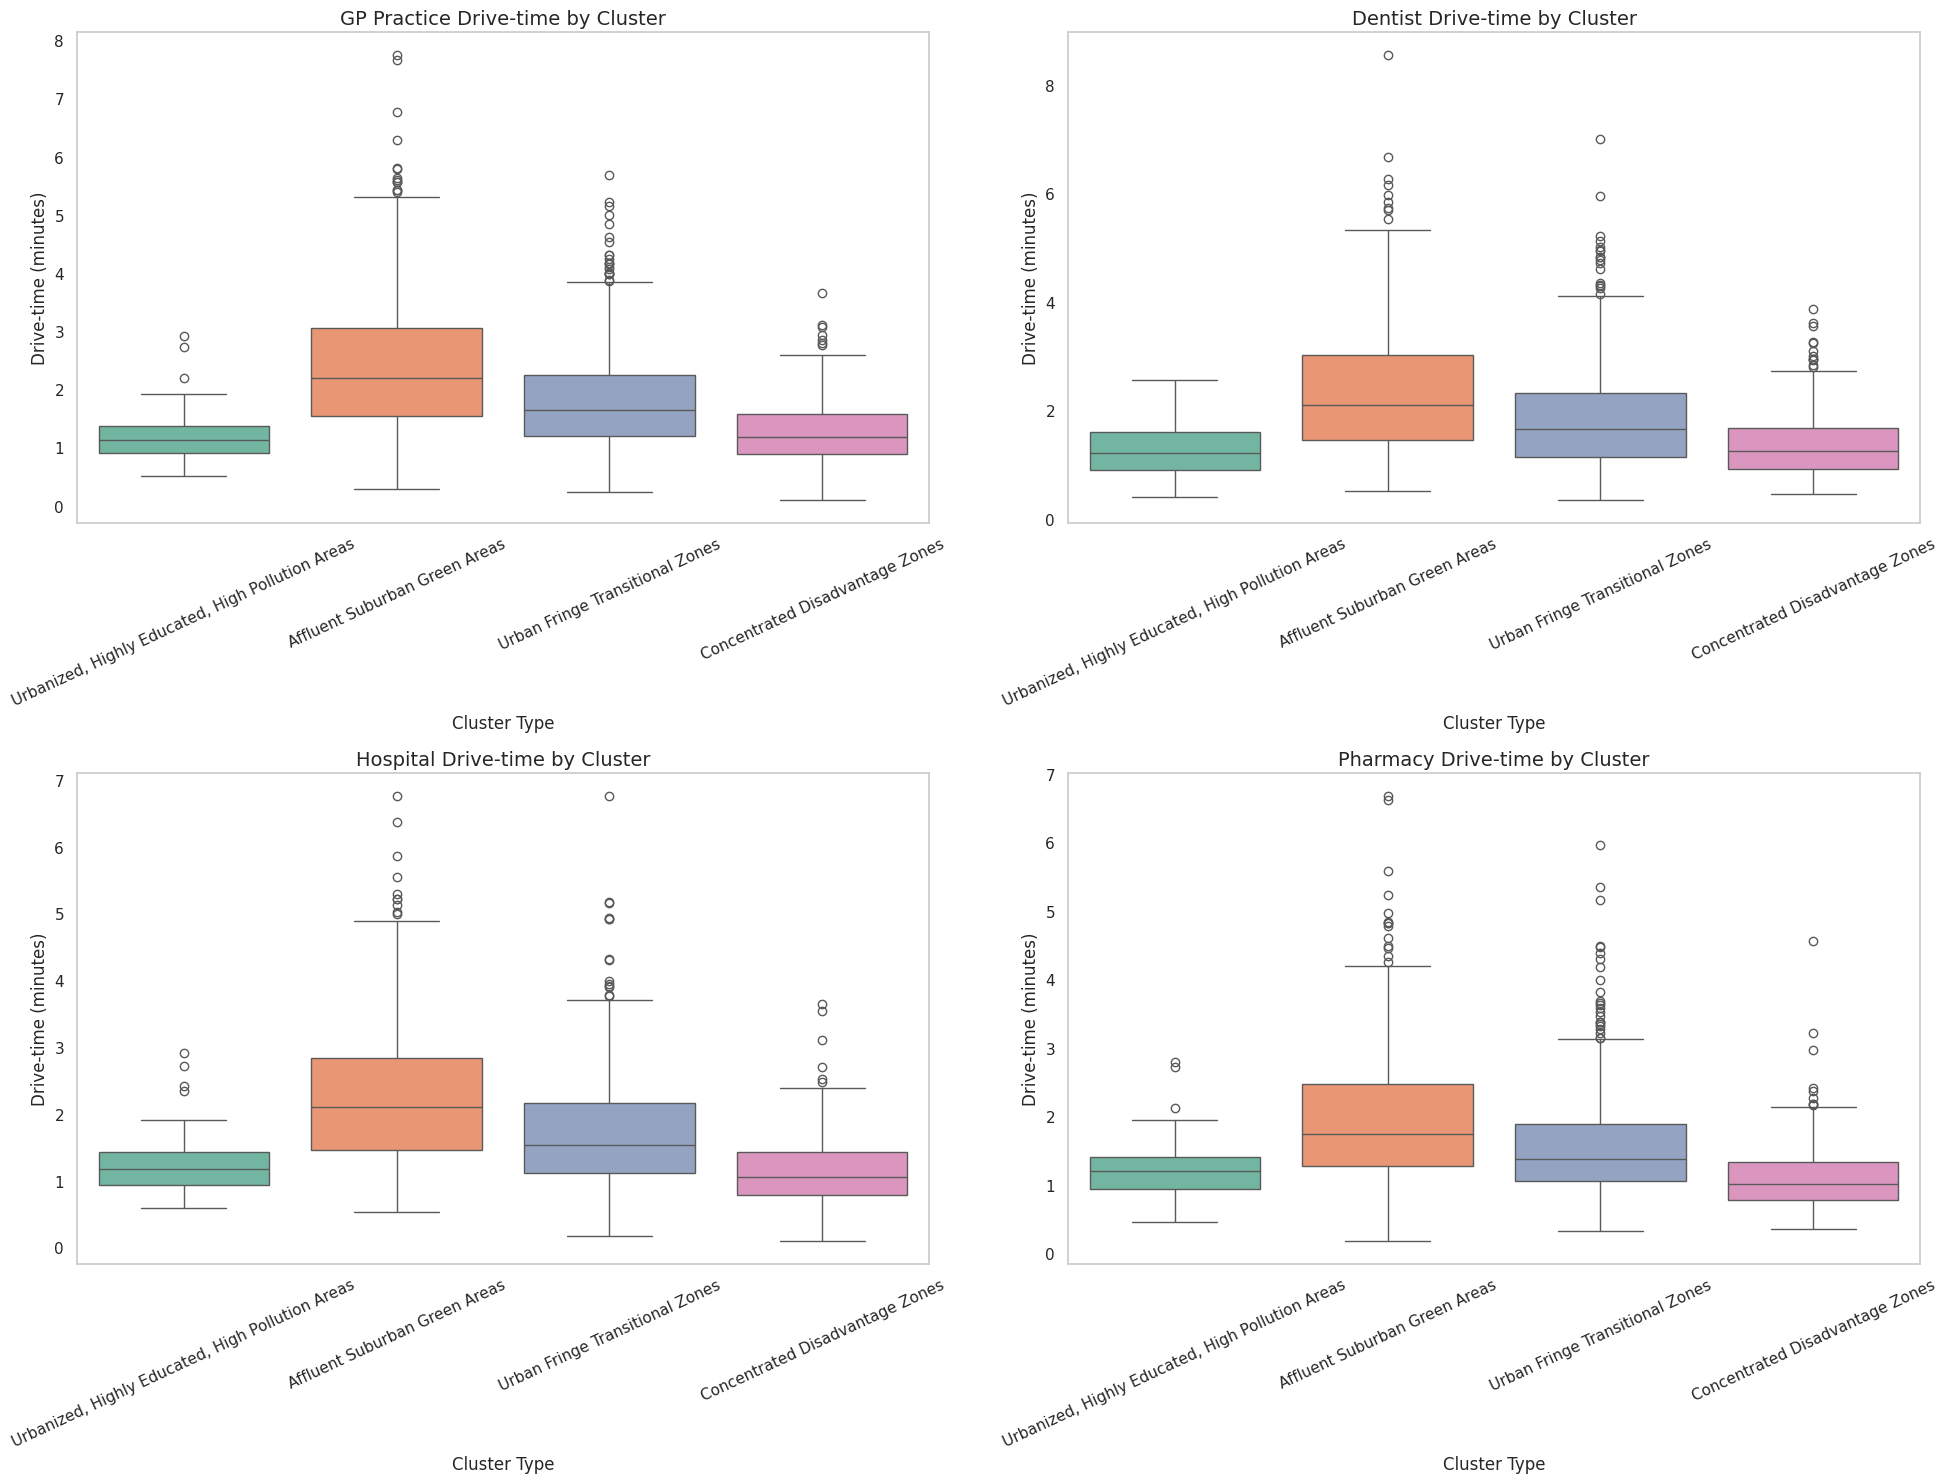

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
merged_gdf1 = lsoa_gdf.merge(cluster_df, on='LSOA21CD', how='left')\
                     .merge(Accessibility[['ah4gp', 'ah4dent', 'ah4hosp', 'ah4phar','LSOA21CD']], on='LSOA21CD', how='left')

sns.set(style="whitegrid")
variables = ['ah4gp', 'ah4dent', 'ah4hosp', 'ah4phar']

# 聚类标签字典
cluster_name_map = {
    0: 'Urbanized, Highly Educated, High Pollution Areas',
    1: 'Affluent Suburban Green Areas',
    2: 'Urban Fringe Transitional Zones',
    3: 'Concentrated Disadvantage Zones'
}

# 给 merged_gdf1 加 cluster_label
merged_gdf1['cluster_label'] = merged_gdf1['cluster'].map(cluster_name_map)


order = [
    'Urbanized, Highly Educated, High Pollution Areas',
    'Affluent Suburban Green Areas',
    'Urban Fringe Transitional Zones',
    'Concentrated Disadvantage Zones',

]

merged_gdf1['cluster_label'] = pd.Categorical(merged_gdf1['cluster_label'], categories=order, ordered=True)


fig, axes = plt.subplots(2, 2, figsize=(20,15))
axes = axes.flatten()

title_map = {
    'ah4gp': 'GP Practice Drive-time by Cluster',
    'ah4dent': 'Dentist Drive-time by Cluster',
    'ah4hosp': 'Hospital Drive-time by Cluster',
    'ah4phar': 'Pharmacy Drive-time by Cluster'
}

for i, var in enumerate(variables):
    sns.boxplot(x='cluster_label', y=var, data=merged_gdf1, ax=axes[i], palette='Set2')
    axes[i].set_title(title_map[var], fontsize=14)
    axes[i].set_xlabel("Cluster Type")
    axes[i].set_ylabel("Drive-time (minutes)")
    axes[i].tick_params(axis='x', rotation=25)
    axes[i].grid(False)

plt.tight_layout()
plt.show()



In [ ]:
#OLS
import statsmodels.api as sm

# Merge two datasets to ensure the dependent and independent variables are in one DataFrame
regression_df = merged_gdf[['LSOA21CD', 'healthy_rate']].merge(
    scaled_df[['LSOA21CD'] + filtered_variables],
    on='LSOA21CD',
    how='inner'
)

# Drop rows with missing values
regression_df = regression_df.dropna()

# Dependent variable
y = regression_df['healthy_rate']

# Independent variables
X = regression_df[filtered_variables]

# Add constant term (intercept)
X = sm.add_constant(X)

# Build the OLS model and fit it
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           healthy_rate   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     198.3
Date:                Thu, 21 Aug 2025   Prob (F-statistic):          2.38e-276
Time:                        02:00:47   Log-Likelihood:                -4251.1
No. Observations:                1702   AIC:                             8524.
Df Residuals:                    1691   BIC:                             8584.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
# Merge two datasets to ensure the dependent and independent variables are in one DataFrame
regression_df = merged_gdf[['LSOA21CD', 'disability_rate']].merge(
    scaled_df[['LSOA21CD'] + filtered_variables],
    on='LSOA21CD',
    how='inner'
)

# Drop rows with missing values
regression_df = regression_df.dropna()

# Dependent variable
y = regression_df['disability_rate']

# Independent variables
X = regression_df[filtered_variables]

# Add constant term (intercept
X = sm.add_constant(X)

# Build the OLS model and fit it
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        disability_rate   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     330.3
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:57:17   Log-Likelihood:                -4019.9
No. Observations:                1702   AIC:                             8062.
Df Residuals:                    1691   BIC:                             8122.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
# Merge two datasets to ensure the dependent and independent variables are in one DataFrame中
regression_df = merged_gdf[['LSOA21CD', 'Very good health_pct']].merge(
    scaled_df[['LSOA21CD'] + filtered_variables],
    on='LSOA21CD',
    how='inner'
)

# Drop rows with missing values
regression_df = regression_df.dropna()

# Dependent variable
y = regression_df['Very good health_pct']

# Independent variables
X = regression_df[filtered_variables]

# Add constant term (intercept
X = sm.add_constant(X)

# Build the OLS model and fit it
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Very good health_pct   R-squared:                       0.600
Model:                              OLS   Adj. R-squared:                  0.597
Method:                   Least Squares   F-statistic:                     253.4
Date:                  Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                          01:57:19   Log-Likelihood:                -4599.6
No. Observations:                  1702   AIC:                             9221.
Df Residuals:                      1691   BIC:                             9281.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [ ]:
# Merge two datasets to ensure the dependent and independent variables are in one DataFrame
regression_df = merged_gdf[['LSOA21CD', 'Poor health_pct']].merge(
    scaled_df[['LSOA21CD'] + filtered_variables],
    on='LSOA21CD',
    how='inner'
)

# Drop rows with missing values
regression_df = regression_df.dropna()

# Dependent variable
y = regression_df['Poor health_pct']

# Independent variables
X = regression_df[filtered_variables]

# Add constant term (intercept
X = sm.add_constant(X)

# Build the OLS model and fit it
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Poor health_pct   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     356.1
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        01:57:26   Log-Likelihood:                -2885.3
No. Observations:                1702   AIC:                             5793.
Df Residuals:                    1691   BIC:                             5852.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
#non_overcrowded_percent
data2= pd.read_csv('https://github.com/kzw333/5160/raw/refs/heads/main/final5.csv')
data2.head()
data2.isnull().sum()
data2.dtypes
data2.columns

Index(['LSOA21CD', '2021 super output area - lower layer',
       'unemployment_rate_percent', 'level4_qualification_percent',
       'detached_housing_percent', 'terraced_housing_percent',
       'total_rent_ratio_percent', 'non_overcrowded_percent',
       'no2_concentration_ugm3', 'so2_concentration_ugm3',
       'pm10_concentration_ugm3', 'ndvi_passive_green_space'],
      dtype='object')

In [ ]:

# 检查data2里是否包含你需要的列
# Check if data2 contains the required columns
print(data2.columns)

# 定义你需要标准化的列（变量）
# Define the columns (variables) you want to standardize
columns_to_scale = [
    'unemployment_rate_percent',
    'level4_qualification_percent',
    'detached_housing_percent',
    'terraced_housing_percent',
    'total_rent_ratio_percent',
    'no2_concentration_ugm3',
    'so2_concentration_ugm3',
    'pm10_concentration_ugm3',
    'ndvi_passive_green_space',
    'non_overcrowded_percent'
]

# 确保data2有这些列，否则会报错
# Ensure that data2 contains these columns, otherwise it will raise an error
missing_cols = [col for col in columns_to_scale if col not in data2.columns]
if missing_cols:
    print(f"警告：data2缺少这些列：{missing_cols}")  # Warning: data2 is missing these columns
else:
    # 进行标准化
    # Standardize the selected columns
    scaler = StandardScaler()
    data2_scaled = scaler.fit_transform(data2[columns_to_scale])

    # 转换为 DataFrame，保留列名
    # Convert to DataFrame and keep column names
    scaled_df2 = pd.DataFrame(data2_scaled, columns=columns_to_scale)

    # 保留标识列
    # Keep identifier columns
    scaled_df2['LSOA21CD'] = data2['LSOA21CD'].values
    scaled_df2['area_name'] = data2['2021 super output area - lower layer'].values

    scaled_df2.head()

# 定义回归使用的标准化变量
# Define the standardized variables to use in regression
filtered_variables2 = [
    'unemployment_rate_percent',
    'level4_qualification_percent',
    'detached_housing_percent',
    'terraced_housing_percent',
    'total_rent_ratio_percent',
    'no2_concentration_ugm3',
    'so2_concentration_ugm3',
    'pm10_concentration_ugm3',
    'ndvi_passive_green_space',
    'non_overcrowded_percent'  # 如果你用这个代替拥挤率 / if you use this instead of overcrowding rate
]


Index(['LSOA21CD', '2021 super output area - lower layer',
       'unemployment_rate_percent', 'level4_qualification_percent',
       'detached_housing_percent', 'terraced_housing_percent',
       'total_rent_ratio_percent', 'non_overcrowded_percent',
       'no2_concentration_ugm3', 'so2_concentration_ugm3',
       'pm10_concentration_ugm3', 'ndvi_passive_green_space'],
      dtype='object')


In [ ]:
# "non_overcrowded_percent"先合并两个数据集，保证因变量和自变量在一个DataFrame中
# Merge the two datasets first to ensure the dependent and independent variables are in one DataFrame
regression_df = merged_gdf[['LSOA21CD', 'Very good health_pct']].merge(
    scaled_df2[['LSOA21CD'] + filtered_variables2],
    on='LSOA21CD',
    how='inner'
)

# 删除缺失值
# Drop missing values
regression_df = regression_df.dropna()

# 因变量
# Dependent variable
y = regression_df['Very good health_pct']

# 自变量
# Independent variables
X = regression_df[filtered_variables2]

# 添加常数项
# Add constant term (intercept)
X = sm.add_constant(X)

# 建立模型并拟合
# Build and fit the OLS regression model
model = sm.OLS(y, X).fit()

# 输出回归结果
# Print the regression results
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     Very good health_pct   R-squared:                       0.600
Model:                              OLS   Adj. R-squared:                  0.597
Method:                   Least Squares   F-statistic:                     253.4
Date:                  Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                          02:13:01   Log-Likelihood:                -4599.5
No. Observations:                  1702   AIC:                             9221.
Df Residuals:                      1691   BIC:                             9281.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

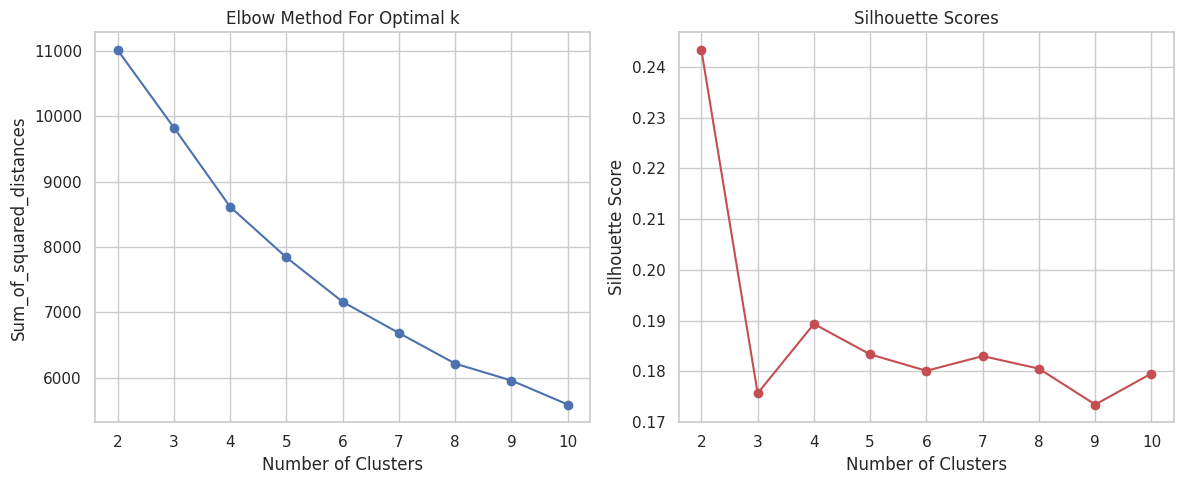

In [ ]:
filtered_variables3 = [
    'unemployment_rate_percent',
    'level4_qualification_percent',
    'detached_housing_percent',
    'terraced_housing_percent',
    'total_rent_ratio_percent',
    'no2_concentration_ugm3',
    'so2_concentration_ugm3',
    'pm10_concentration_ugm3',
    'ndvi_passive_green_space',
]

# 1. 选择标准化后的变量列用于聚类（filtered_variables3 是列名列表）
# Select standardized variables for clustering (filtered_variables3 is the list of column names)
X = scaled_df2[filtered_variables3]

# 2. 初始化存储列表
# Initialize lists to store results
wcss = []        # Within-cluster sum of squares
sil_scores = []  # Silhouette scores
K_range = range(2, 11)  # Candidate number of clusters

# 3. 计算不同 k 的聚类效果
# Compute clustering performance for different k values
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)                       # 聚类误差平方和 (WCSS)
    sil_scores.append(silhouette_score(X, kmeans.labels_))  # 轮廓系数 (Silhouette score)

# 4. 可视化肘部法和轮廓系数
# Visualize Elbow Method and Silhouette Scores
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum_of_squared_distances')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [ ]:
# 1. 执行KMeans聚类，k=4
# Perform KMeans clustering with k=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
scaled_df2['cluster'] = kmeans.fit_predict(X)

# 查看前几行确认
# Check the first few rows to verify
print(scaled_df2[['LSOA21CD', 'cluster'] + filtered_variables3].head())
print(scaled_df2[['LSOA21CD', 'cluster'] + filtered_variables3].tail())

# 2. 统计分析：每个簇的均值
# Statistical analysis: compute mean of each cluster
cluster_summary = scaled_df2.groupby('cluster')[filtered_variables3].mean()
print(cluster_summary)



    LSOA21CD  cluster  unemployment_rate_percent  \
0  E01004768        3                  -1.010988   
1  E01004803        3                  -1.033790   
2  E01004804        3                  -0.369996   
3  E01004807        3                  -0.382664   
4  E01004808        3                  -0.704427   

   level4_qualification_percent  detached_housing_percent  \
0                      0.558960                  3.058749   
1                      0.932936                  1.578095   
2                      1.110416                  2.807508   
3                      0.679393                  1.045250   
4                      0.909959                  1.700738   

   terraced_housing_percent  total_rent_ratio_percent  no2_concentration_ugm3  \
0                 -1.170880                 -1.452846               -1.570106   
1                 -0.002376                 -0.983903               -2.163557   
2                 -0.918162                 -1.409032               -1.826105

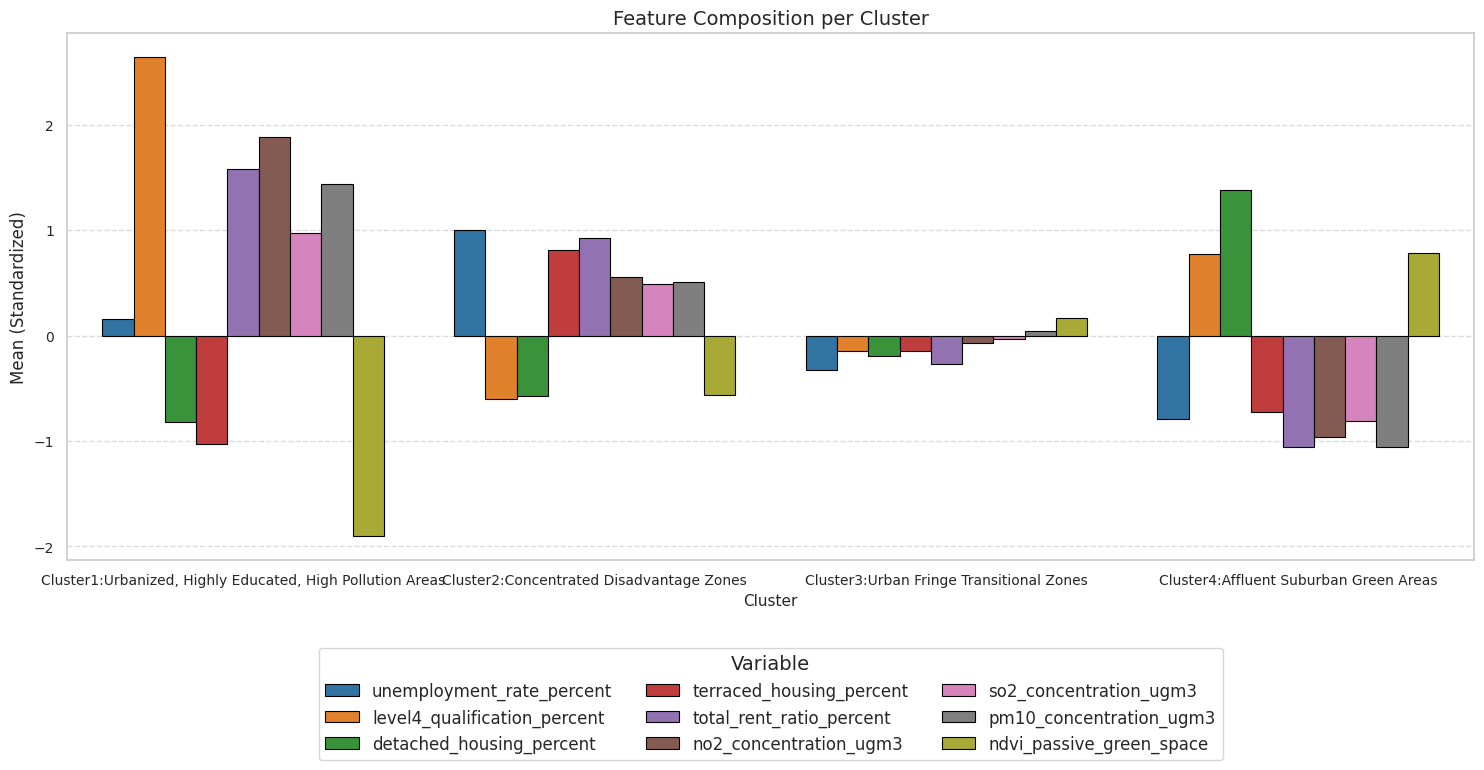

In [ ]:
# 1. 计算每个簇的均值（标准化后的变量）
# Compute the mean of each cluster (standardized variables)
cluster_summary = scaled_df2.groupby('cluster')[filtered_variables3].mean()

# 2. 转换成长格式，方便绘图
# Convert to long format for easier plotting
cluster_summary_long = cluster_summary.reset_index().melt(
    id_vars='cluster',
    var_name='variable',
    value_name='mean_value'
)

# 3. 定义簇名称映射（假设4个簇）
# Define cluster name mapping (assuming 4 clusters)
cluster_name_map = {
    0: 'Cluster1:Urbanized, Highly Educated, High Pollution Areas',
    1: 'Cluster2:Concentrated Disadvantage Zones',
    2: 'Cluster3:Urban Fringe Transitional Zones',
    3: 'Cluster4:Affluent Suburban Green Areas'
}

# 4. 替换 cluster 数字为对应名称
# Map cluster numbers to descriptive names
cluster_summary_long['cluster'] = cluster_summary_long['cluster'].map(cluster_name_map)

# 5. 自定义颜色，确保颜色数量和变量数量一致
# Define custom color palette, ensure number of colors matches number of variables
custom_palette = sns.color_palette("tab10", n_colors=len(filtered_variables3))

# 6. 绘制条形图
# Plot bar chart
plt.figure(figsize=(15,8))
barplot = sns.barplot(
    data=cluster_summary_long,
    x='cluster',
    y='mean_value',
    hue='variable',
    palette=custom_palette,
    edgecolor='black',
    linewidth=0.8
)

plt.xlabel('Cluster', fontsize=11)  # x轴标签
plt.ylabel('Mean (Standardized)', fontsize=12)  # y轴标签
plt.title('Feature Composition per Cluster', fontsize=14)  # 标题

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 图例放底部居中，多列显示
# Place legend at bottom center with multiple columns
plt.legend(
    title='Variable',
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    ncol=3,
    fontsize=12,
    title_fontsize=14
)

# 加横向网格线，方便比较数值高度
# Add horizontal grid lines for easier value comparison
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


/tmp/ipython-input-767621281.py:46: UserWarning: 
The palette list has fewer values (9) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipython-input-767621281.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-767621281.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


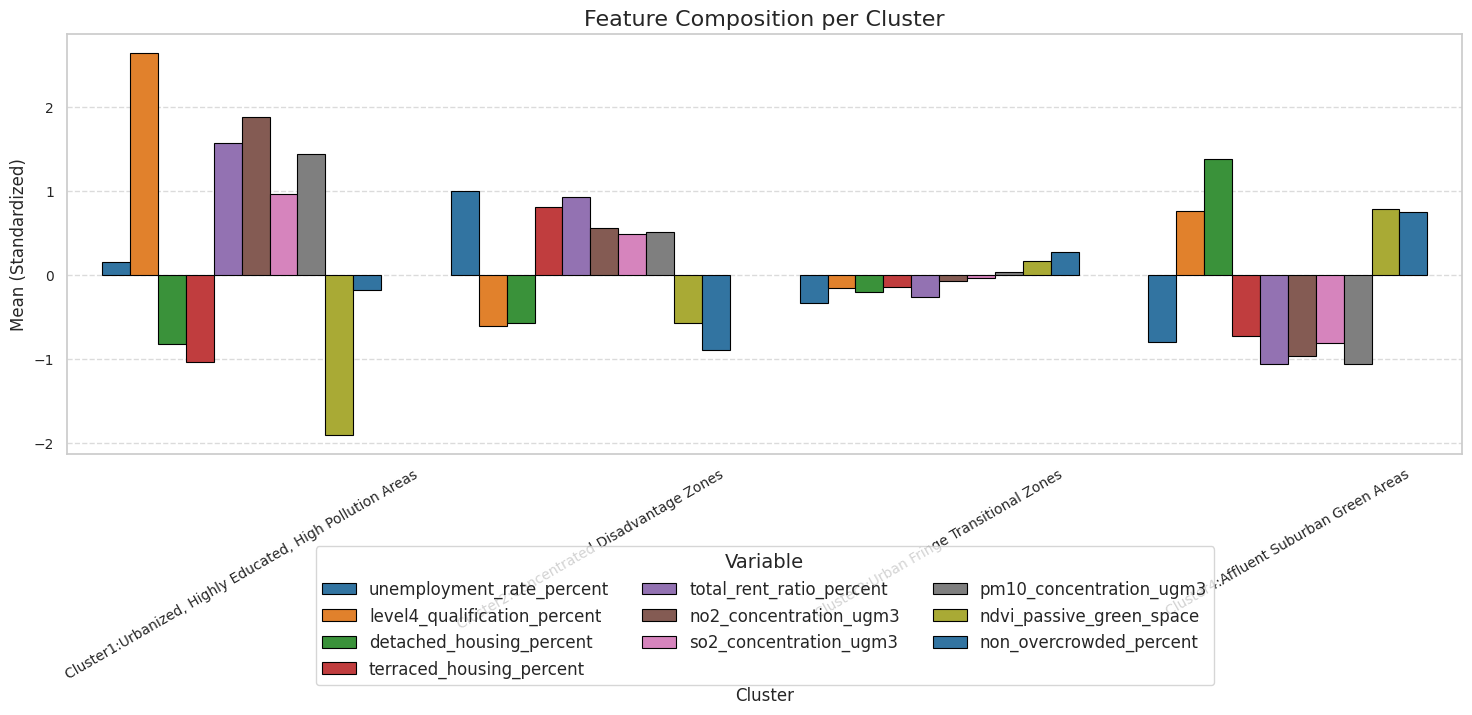

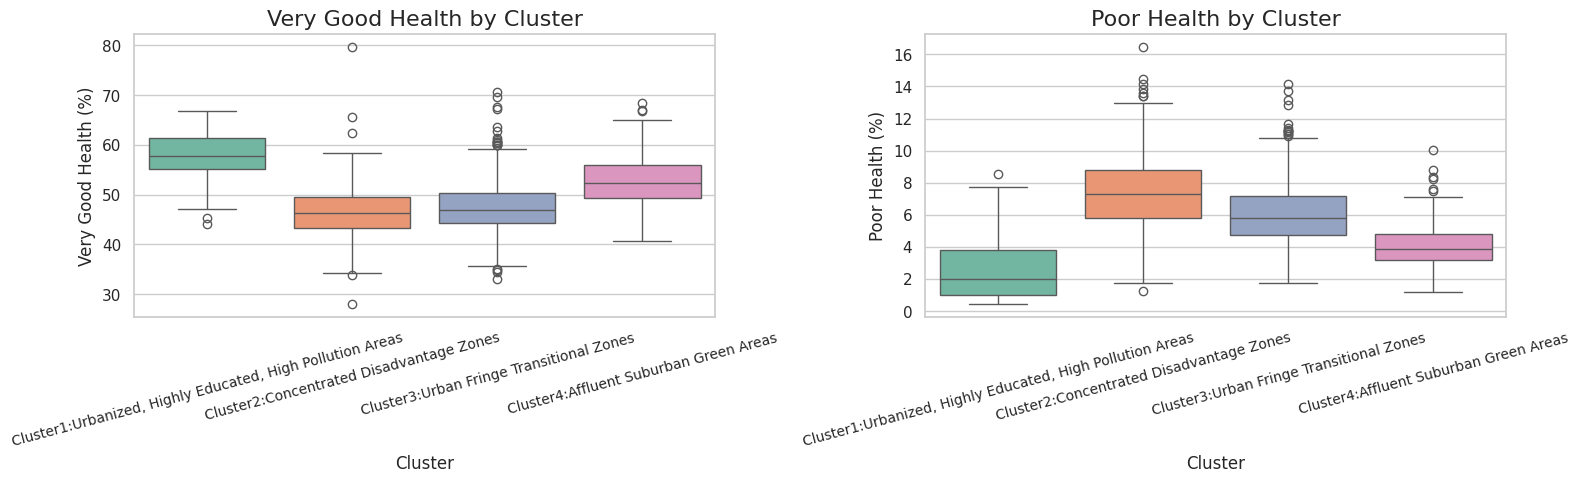

                                                   disability_rate             \
                                                             count       mean   
cluster_label                                                                   
Cluster1:Urbanized, Highly Educated, High Pollu...            58.0  11.978621   
Cluster2:Concentrated Disadvantage Zones                     529.0  20.218563   
Cluster3:Urban Fringe Transitional Zones                     753.0  19.044635   
Cluster4:Affluent Suburban Green Areas                       362.0  15.553895   

                                                                             \
                                                         std   min      25%   
cluster_label                                                                 
Cluster1:Urbanized, Highly Educated, High Pollu...  3.597133  7.41   9.1350   
Cluster2:Concentrated Disadvantage Zones            4.619454  8.68  16.7500   
Cluster3:Urban Fringe Transitional Zo

/tmp/ipython-input-767621281.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-767621281.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


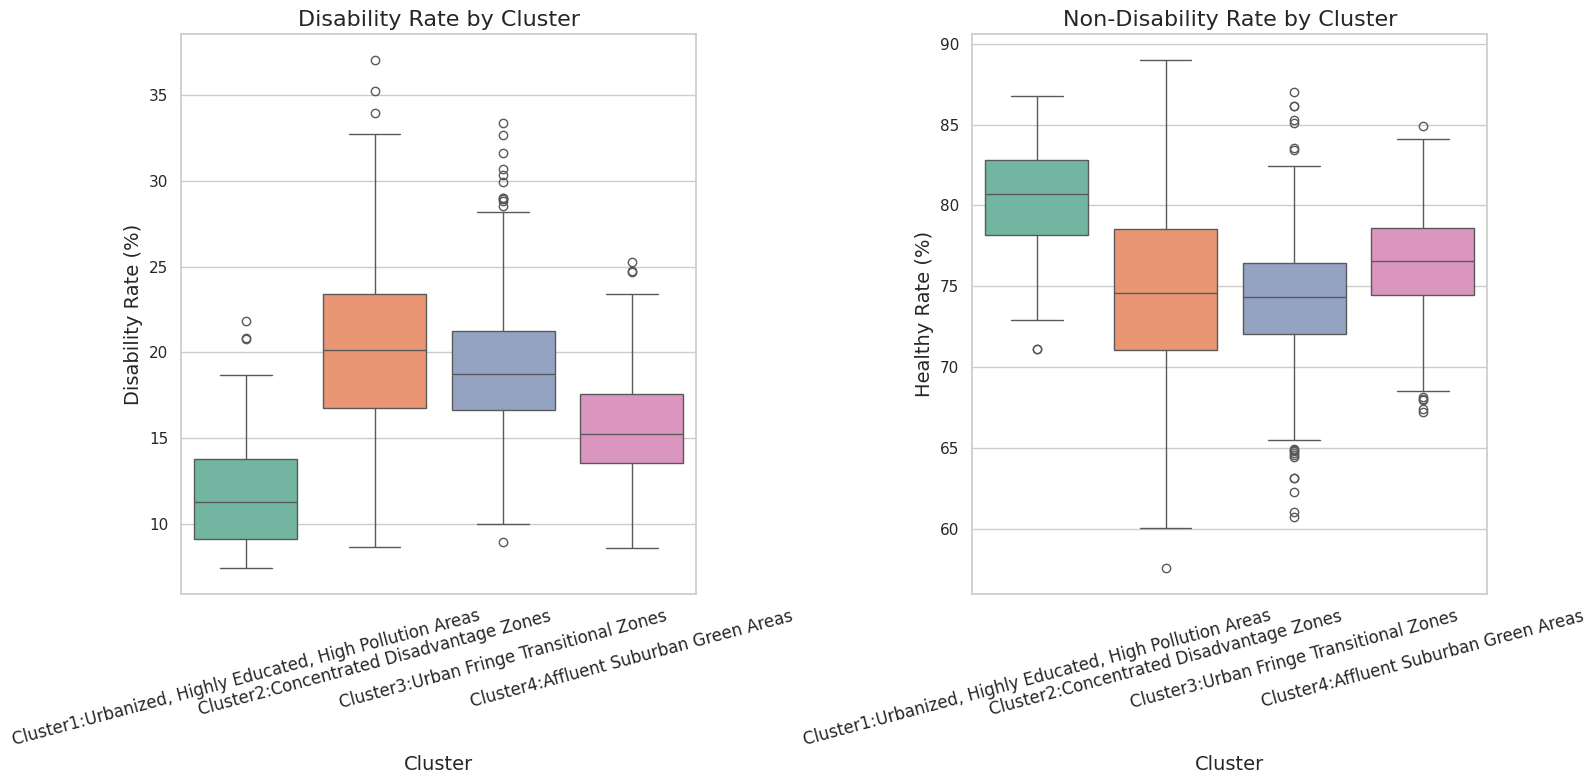

In [ ]:
# --- 1. 定义簇名称映射 / Define cluster name mapping ---
cluster_name_map = {
    0: 'Cluster1:Urbanized, Highly Educated, High Pollution Areas',
    1: 'Cluster2:Concentrated Disadvantage Zones',
    2: 'Cluster3:Urban Fringe Transitional Zones',
    3: 'Cluster4:Affluent Suburban Green Areas'
}

# --- 2. 计算每个簇的均值（标准化变量） / Calculate mean of standardized variables per cluster ---
cluster_summary = scaled_df2.groupby('cluster')[filtered_variables2].mean()

# --- 3. 转换成长格式方便绘图 / Convert to long format for plotting ---
cluster_summary_long = cluster_summary.reset_index().melt(
    id_vars='cluster',
    var_name='variable',
    value_name='mean_value'
)
cluster_df2 = scaled_df2[['LSOA21CD', 'cluster']].copy()

merged_gdf2 = lsoa_gdf.merge(cluster_df2, on='LSOA21CD', how='left')\
                       .merge(healthdata[['LSOA21CD', 'Very good health_pct', 'Poor health_pct']], on='LSOA21CD', how='left')\
                       .merge(Disability[['LSOA21CD', 'disability_rate', 'healthy_rate']], on='LSOA21CD', how='left')

# --- 4. 替换数字簇为对应的字符串名称 / Replace numeric cluster with string labels ---
cluster_summary_long['cluster'] = cluster_summary_long['cluster'].map(cluster_name_map)

# --- 5. 给 merged_gdf 添加映射后的簇标签列 / Add cluster label column to merged_gdf ---
merged_gdf2['cluster_label'] = merged_gdf2['cluster'].map(cluster_name_map)

# --- 6. 设定簇显示顺序，保证图表顺序一致 / Set cluster display order to ensure consistent plot order ---
cluster_order = [
    'Cluster1:Urbanized, Highly Educated, High Pollution Areas',
    'Cluster2:Concentrated Disadvantage Zones',
    'Cluster3:Urban Fringe Transitional Zones',
    'Cluster4:Affluent Suburban Green Areas'
]

# --- 7. 自定义颜色，变量数目对应 / Define custom color palette matching number of variables ---
custom_palette = sns.color_palette("tab10", n_colors=len(filtered_variables3))

# --- 8. 绘制图形 / Plotting ---
plt.figure(figsize=(18, 12))

# 8.1 条形图：各簇标准化变量均值 / Bar plot: mean standardized variables per cluster
plt.subplot(2, 1, 1)
sns.barplot(
    data=cluster_summary_long,
    x='cluster',
    y='mean_value',
    hue='variable',
    palette=custom_palette,
    edgecolor='black',
    linewidth=0.8,
    order=cluster_order
)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Mean (Standardized)', fontsize=12)
plt.title('Feature Composition per Cluster', fontsize=16)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Variable', bbox_to_anchor=(0.5, -0.2), loc='upper center',
           ncol=3, fontsize=12, title_fontsize=14)

# 8.2 箱线图：健康指标在各簇分布 / Boxplot: Health indicators distribution across clusters
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 3)
sns.boxplot(
    x='cluster_label',
    y='Very good health_pct',
    data=merged_gdf2,
    order=cluster_order,
    palette='Set2'
)
plt.title('Very Good Health by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Very Good Health (%)', fontsize=12)
plt.xticks(rotation=15, fontsize=10)

plt.subplot(2, 2, 4)
sns.boxplot(
    x='cluster_label',
    y='Poor health_pct',
    data=merged_gdf2,
    order=cluster_order,
    palette='Set2'
)
plt.title('Poor Health by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Poor Health (%)', fontsize=12)
plt.xticks(rotation=15, fontsize=10)

plt.tight_layout()
plt.show()

# 描述性统计 / Descriptive statistics
disability_stats = merged_gdf2.groupby('cluster_label')[['disability_rate', 'healthy_rate']].describe()
print(disability_stats)

# 绘制残疾率和非残疾率箱线图 / Boxplots of disability and healthy rates
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxplot(
    x='cluster_label',
    y='disability_rate',
    data=merged_gdf2,  # 改这里 / update data
    order=cluster_order,
    palette='Set2'
)
plt.title('Disability Rate by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Disability Rate (%)', fontsize=14)
plt.xticks(rotation=15, fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(
    x='cluster_label',
    y='healthy_rate',
    data=merged_gdf2,  # 改这里 / update data
    order=cluster_order,
    palette='Set2'
)
plt.title('Non-Disability Rate by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Healthy Rate (%)', fontsize=14)
plt.xticks(rotation=15, fontsize=12)

plt.tight_layout()
plt.show()


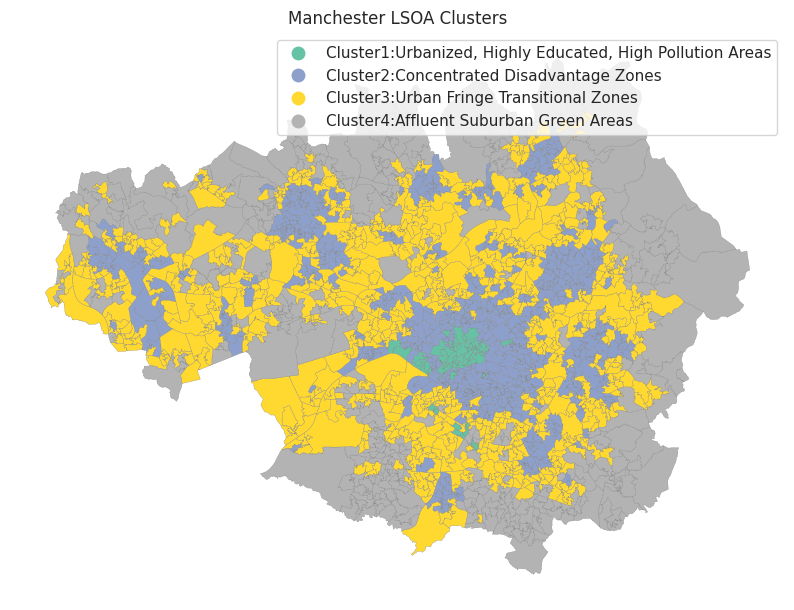

In [ ]:
# 1. 按聚类标签绘制分类地图（不同聚类不同颜色）
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_gdf2.plot(column='cluster_label',
                 categorical=True,
                 legend=True,
                 linewidth=0.2,
                 edgecolor='gray',
                 ax=ax,
                 cmap='Set2')  # Set2适合分类色彩
ax.set_title('Manchester LSOA Clusters')
ax.axis('off')
plt.show()